In [1]:
# ------------------------------------------------
# Script for data analysis
# Full name: 3d_revised_axial_grid_reflecting_version3_analysis
# ("3d cylinder" in the paper)
# ------------------------------------------------

using StatsBase
using Distributions
using Plots
using SpecialFunctions
using Serialization

default(margin=6Plots.mm) # plot parameters
thisfilename = Base.basename(@__FILE__)
anim_count = 1

1

In [2]:
# Input parameters
# ------------------------------------------------

const BURN_IN_GEN_N = 1000
const TOTAL_GEN_N = 2000

# Max coordinates of the population bounding space
# (population = cylinder)
const R_MAX = 10
const Z_MAX = 300
const Z_MAX_BURN_IN = 5

const X_MAX = R_MAX
const Y_MAX = R_MAX
#= # (population = cube)
const X_MAX = 5
const Y_MAX = 5
const Z_MAX = 50
const Z_MAX_BURN_IN = 5 =#

# (population reaches space bounds)
const X_START = X_MAX
const Y_START = Y_MAX
# (population starts out twice smaller)
#const X_START = trunc(X_MAX/2)
#const Y_START = trunc(Y_MAX/2)

const Z_START = Z_MAX_BURN_IN

# Dimensions of the whole space
const X_DIM = 2*X_MAX+1
const Y_DIM = 2*Y_MAX+1
const Z_DIM = Z_MAX

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.05
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 0.9
const S_SELECT_COEF = 0.005

0.005

In [3]:
# Data loading
# ------------------------------------------------

const N_IN_BATCH = 10  # Use the generation program (3d_ra_gridrefl3.jl) to generate 11 data iterates and load them below:

padding = zeros(Float32,X_DIM,Y_DIM,Z_DIM,BURN_IN_GEN_N)
meanfitness_set_noburn = [cat(padding,deserialize("../data/3d_axial/lrs_gridrefl3_lat_noburn_$i-meanf.dat"),dims=4) for i in 1:N_IN_BATCH]
meanfitness_set = [deserialize("../data/3d_axial/lrs_gridrefl3_lat_$i-meanf.dat") for i in 1:N_IN_BATCH]

10-element Vector{Array{Float32, 4}}:
 [-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; … ;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; … ;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.

In [4]:
# Functions pertaining to the expansion front
# ------------------------------------------------

function find_front_array(meanfit_array,oneside=false)
    front_array = zeros(X_DIM,Y_DIM,Z_DIM,TOTAL_GEN_N)
    for j in 1:TOTAL_GEN_N
        # scanning every xy: side 1
        for _x in 1:X_DIM,_y in 1:X_DIM
            frontier_z = Z_DIM
            while frontier_z != 1 && meanfit_array[_x,_y,frontier_z,j] < 0
                frontier_z -= 1
            end
            if meanfit_array[_x,_y,frontier_z,j]>0
                front_array[_x,_y,frontier_z,j]=meanfit_array[_x,_y,frontier_z,j]
            end
        end
        # scanning every xy: side 2
        if !oneside
            for _x in 1:X_DIM,_y in 1:X_DIM
                frontier_z = 1
                while frontier_z != Z_DIM && meanfit_array[_x,_y,frontier_z,j] < 0
                    frontier_y += 1
                end
                if meanfit_array[_x,_y,frontier_z,j]>0
                    front_array[_x,_y,frontier_z,j]=meanfit_array[_x,_y,frontier_z,j]
                end
            end
        end
    end
    return front_array
end

# Used to normalise a front ARRAY and returns the mean values, but in the order III
function FFA_offset_mean(front_array,every_gen=false)
    _mean_front = Array{Float32}(undef,0)
    
    for j in 1:TOTAL_GEN_N
        sum = 0
        count = 0
        for u in front_array[:,:,:,j]
            if u > 0
                sum += u
                count += 1
            end
        end
        if j==BURN_IN_GEN_N+1
            append_val = 1
        elseif j>BURN_IN_GEN_N+1
            append_val = sum/count/_mean_front[BURN_IN_GEN_N+1]
        else
            append_val = sum/count
        end
        _mean_front = cat(_mean_front,append_val,dims=1)
    end

    return _mean_front
end

# Normalises the meanfitness matrix using the 1st method (after BURN_IN_GEN, divide by the maximum of each generation)
function normalise_all_by_maximum(meanfit_array)
    normal_array = copy(meanfit_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanfit_array[:,:,:,BURN_IN_GEN_N+j])
        normal_array[:,:,:,BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

# Normalises the meanfitness matrix using the 3rd method (after BURN_IN_GEN, divide by the constant value of average fitness over all demes at BURN_IN_GEN_N+1)
function normalise_all_by_onset_mean(meanfit_array,offs=0)
    normal_array = copy(meanfit_array)

    sum = 0
    count = 0
    for u in meanfit_array[:,:,:,BURN_IN_GEN_N+1+offs]
        if u > 0
            sum += u
            count += 1
        end
    end
    gen_average = sum/count

    normal_array[:,:,:,BURN_IN_GEN_N+1:end] /= gen_average
    return normal_array
end

function find_front(meanfit_array,oneside=false)
    front_array = Array{Float64}(undef,0)
    for j in 1:TOTAL_GEN_N
        sum_total = 0
        cnt = 0
        # scanning every xy: side 1
        for _x in 1:X_DIM,_y in 1:X_DIM
            frontier_z = Z_DIM
            while frontier_z != 1 && meanfit_array[_x,_y,frontier_z,j] < 0
                frontier_z -= 1
            end
            if meanfit_array[_x,_y,frontier_z,j]>0
                sum_total += meanfit_array[_x,_y,frontier_z,j]
                cnt += 1
            end
        end
        # scanning every xy: side 2
        if !oneside
            for _x in 1:X_DIM,_y in 1:X_DIM
                frontier_z = 1
                while frontier_z != Z_DIM && meanfit_array[_x,_y,frontier_z,j] < 0
                    frontier_y += 1
                end
                if meanfit_array[_x,_y,frontier_z,j]>0
                    sum_total += meanfit_array[_x,_y,frontier_z,j]
                    cnt += 1
                end
            end
        end
        mean_both_sides_xy = sum_total/cnt

        if !oneside
            sum_total = 0
            cnt = 0
            # scanning every yz: side 1
            # !!implement
            # scanning every yz: side 2
            # !!implement
            mean_both_sides_yz = sum_total/cnt

            # scanning every xz: side 1
            # !!implement
            # scanning every xz: side 2
            # !!implement
            mean_both_sides_xz = sum_total/cnt

            front_array = cat(front_array,(mean_both_sides_xy+mean_both_sides_yz+mean_both_sides_xz)/3, dims=1)
        else
            front_array = cat(front_array,mean_both_sides_xy, dims=1)
        end
    end
    return front_array
end

function normalise_front_by_onset_mean(average_1d_array)
    normal_array = copy(average_1d_array)
    normal_array[BURN_IN_GEN_N+1:end] /= average_1d_array[BURN_IN_GEN_N+1]
    return normal_array
end

function normalise_front_by_max(average_1d_array,meanf_array)
    normal_array = copy(average_1d_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanf_array[:,:,:,BURN_IN_GEN_N+j])
        normal_array[BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

normalise_front_by_max (generic function with 1 method)

In [5]:
# Normalisation algorithm (order) I  (heavy so I commented it)
# ------------------------------------------------

#= mf_norm_set = [normalise_all_by_maximum(k) for k in meanfitness_set]
mf_front_norm_set = [find_front(k,true) for k in mf_norm_set]
mf_front_norm_matrix = reduce(hcat,mf_front_norm_set)'
mf_front_norm_average = [mean(mf_front_norm_matrix[:,i]) for i in 1:TOTAL_GEN_N] =#

mf_norm_set2 = [normalise_all_by_onset_mean(k) for k in meanfitness_set]
mf_front_norm_set2 = [find_front(k,true) for k in mf_norm_set2]
mf_front_norm_matrix2 = reduce(hcat,mf_front_norm_set2)'
mf_front_norm_average2 = [mean(mf_front_norm_matrix2[:,i]) for i in 1:TOTAL_GEN_N]

2000-element Vector{Float64}:
 1.0
 0.9995583355426788
 0.9992594003677369
 0.9988375782966614
 0.9984126329421997
 0.9980086147785187
 0.9977036535739898
 0.9973256766796113
 0.9968230485916137
 0.9964209079742432
 ⋮
 0.7007873892784119
 0.7007186949253082
 0.7005518078804016
 0.7002189517021179
 0.7000726103782654
 0.6998550415039062
 0.6996247708797455
 0.6992183923721313
 0.6989339113235473

In [48]:
# 3D heatmap function
# ------------------------------------------------

using GLMakie

toNaN(x) = x < 0 ? NaN : x

function plot_3d_heatstack(sc,xs,heights,arr3d;minval=0.79,maxval=1.21,custom_title=-1)
    data = toNaN.(arr3d)
    ax = Axis3(sc[1, 1], aspect=(1, 1, 1), elevation=π/6)
    if custom_title!=-1
        ax.title=string("gen = ",custom_title)
    end

    cr = (minval, maxval) # color range to use for all heatmaps
    for i in heights
        hm = GLMakie.heatmap!(ax, xs, xs, data[:, :, i], colorrange=cr,colormap=(:thermal,0.25))
        GLMakie.translate!(hm, 0, 0, heights[i])
        
        i == 1 && Colorbar(sc[1, 2], hm) # add the colorbar once
    end

    GLMakie.zlims!(ax, minimum(heights), maximum(heights))
    sc
end

function anim_from_to(gen_start,gen_end;minval=0.79,maxval=1.21)
    scene = Figure()
    
    record(scene, "../animations/$thisfilename--$anim_count.mp4") do io
        for i=gen_start:gen_end
            plot_3d_heatstack(scene,1:X_DIM,1:Z_DIM,mf_norm_set2[1][:,:,:,i];minval=minval,maxval=maxval,custom_title=string(i-BURN_IN_GEN_N))
            recordframe!(io)
            empty!(scene)
        end
    end

    global anim_count += 1
end

anim_from_to (generic function with 1 method)

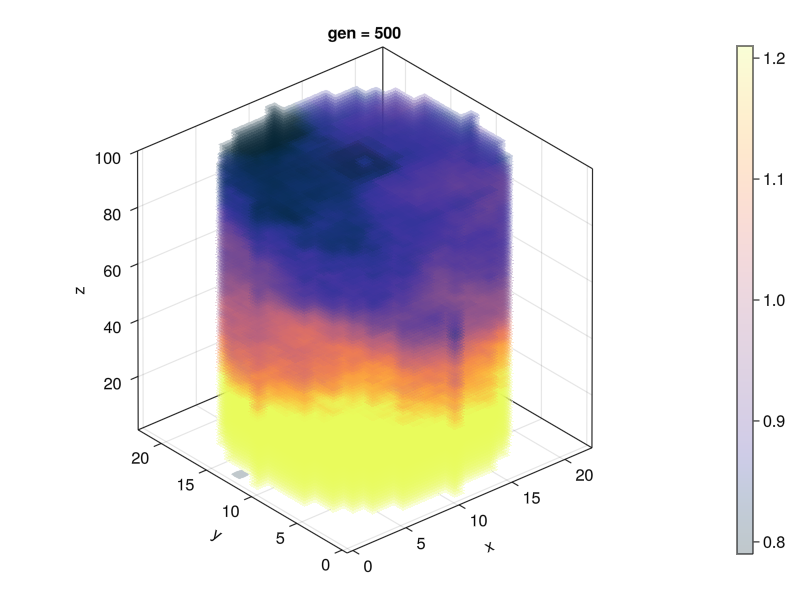

In [44]:
scene_temp = Figure()
plot_3d_heatstack(scene_temp,1:X_DIM,1:100,mf_norm_set2[1][:,:,:,1500];minval=0.79,maxval=1.21,custom_title=500)

In [45]:
# Make 3D heatmap animation for 1 replicate
# ------------------------------------------------

anim_from_to(990,1100)
anim_from_to(1900,2000;minval=0.4,maxval=1.5)

5

In [8]:
# Clear memory for order I
# ------------------------------------------------

mf_norm_set2 = 0
mf_front_norm_set2 = 0
mf_front_norm_matrix2 = 0

0

In [26]:
# Normalisation algorithm (order) II
# ------------------------------------------------

# Onset mean normalisation
mf_front_set = [find_front(meanfitness_set[i],true) for i in 1:N_IN_BATCH]
mf_front_matrix = reduce(hcat,mf_front_set)'
mf_front_average = [mean(mf_front_matrix[:,i]) for i in 1:TOTAL_GEN_N]
mf_front_matrix = 0
mf_front_average_then_norm2 = normalise_front_by_onset_mean(mf_front_average)

# Maximum normalisation
mf_front_norm_set1 = [normalise_front_by_max(mf_front_set[i],meanfitness_set[i]) for i in 1:N_IN_BATCH]
mf_front_norm_matrix1 = reduce(hcat,mf_front_norm_set1)'
mf_front_norm_average1 = [mean(mf_front_norm_matrix1[:,i]) for i in 1:TOTAL_GEN_N]

2000-element Vector{Float64}:
 1.0
 0.9995583355426788
 0.9992594003677369
 0.9988375782966614
 0.9984126329421997
 0.9980086147785187
 0.9977036535739898
 0.9973256766796113
 0.9968230485916137
 0.9964209079742432
 ⋮
 0.23309577416384122
 0.233044415272952
 0.2326417700502638
 0.2320634484458018
 0.23178084796202905
 0.23172107300794115
 0.23104387549556277
 0.23081225392626709
 0.2303265282429642

In [27]:
# No-burn
mf_front_set_noburn = [find_front(k,true) for k in meanfitness_set_noburn]
mf_front_matrix_noburn = reduce(hcat,mf_front_set_noburn)'
mf_front_average_noburn = [mean(mf_front_matrix_noburn[:,i]) for i in 1:TOTAL_GEN_N]

2000-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
   0.6896971106529236
   0.6892510175704956
   0.6889180243015289
   0.6886303663253784
   0.6882237374782563
   0.6882149875164032
   0.6880241870880127
   0.6877548277378083
   0.6873687922954559

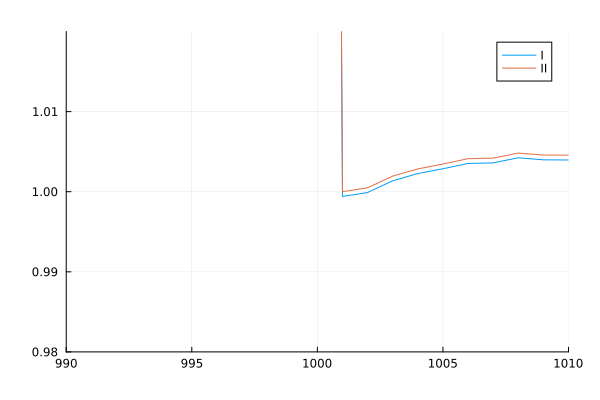

In [28]:
# Compare "onset mean normalisation" for orders I & II
# ------------------------------------------------

Plots.plot(mf_front_norm_average2,label="I")
Plots.plot!(mf_front_average_then_norm2,label="II",xlims=(990,1010),ylims=(0.98,1.02))

In [12]:
# Normalisation algorithm (order) III
# ------------------------------------------------

#= mf_front_set2_FFA = [find_front_array(k,true) for k in meanfitness_set]
mf_front_norm_set2_FFA = [normalise_front_offset_mean(k) for k in mf_front_set2_FFA]
mf_front_norm_matrix2_FFA = reduce(hcat,mf_front_norm_set2_FFA)'
mf_front_norm_average2_FFA = [mean(mf_front_norm_matrix2_FFA[:,i]) for i in 1:TOTAL_GEN_N] =#

In [13]:
#=plot(mf_front_norm_average2,xlims=(BURN_IN_GEN_N+1,TOTAL_GEN_N),ylims=(0.9,1.1))
plot!(mf_front_norm_average2_FFA) =#

In [14]:
#= p = plot(mf_front_norm_set2[1][BURN_IN_GEN_N+1:end],label = "Simul.#1",xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.66,1.08))

for i in 2:N_IN_BATCH
    p = plot!(mf_front_norm_set2[i][BURN_IN_GEN_N+1:end],label = "Simul.#$i",legend=false,xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.66,1.08))
end
display(p) =#

In [29]:
# Analytical function definitions
# ------------------------------------------------

function N_t(m,r,K,t)
    x_ = (m/2)*K*exp(r*t)
    if x_ >= K
        x_ =  K
    end
    return x_
end

function growth_T(m,r)
    return log(2/m)/r
end

function s_e(s,m,r)
    return s*(m/2)*growth_T(m,r)
end

function x0(s,m,r,K,t)
    x_ = exp(s*(growth_T(m,r)-t))
    x_ /= (exp(s*(growth_T(m,r)-t))+2*N_t(m,r,K,t)-1)
    return x_
end

function u_p_cubic(P,s,m,r,K)
    local myexp = exp(s*growth_T(m,r))
    
    return (3*myexp*(myexp-1)*P-K*m*((myexp-1)*P+1)^3+K*m)/(3*myexp*(myexp-1)-K*m*myexp^3+K*m)
end

h2(s,m,r,K) = sqrt(exp(-s*growth_T(m,r))*K*m) # A* in my PDF
h1(s,m,r) = expm1(s*growth_T(m,r)) # B in my PDF

function u_p(P,s,m,r,K)
    local myh1 = h1(s,m,r)
    local myh2 = h2(s,m,r,K)
    u_ = erf(myh1*myh2*P+myh2)-erf(myh2)
    u_ /= erf(myh1*myh2+myh2)-erf(myh2)
    return u_
end

function u_p_peischl(P,s,m,r,K)
    local mys_e = s_e(s,m,r)
    u_ = expm1(-4*mys_e*K_CAPACITY*P)
    u_ /= expm1(-4*mys_e*K_CAPACITY)
    return u_
end

#= function u_p_alt(P,s,m,r,K)
    myA = s*growth_T(m,r)
    myB = 2/K/m
    u_1 = (-1+0im)^myB * _₂F₁(1,myB,2+myB,1-exp(myA))
    u_ = u_1 / ((P-1+0im)^(1+myB) * exp(-myB*myA) * _₂F₁(myB,1+myB,2+myB,(exp(-myA)-1)*(P-1)) + u_1)
    return u_
end =#
function u_p_alt(P,s,m,r,K)
    myA = expm1(s*growth_T(m,r))
    myB = 2/K/m + 1
    u_ = ((myA*P+1)^myB - 1)/((myA+1)^myB - 1)
    return u_
end

u_p_alt (generic function with 1 method)

In [30]:
LOCI_N_THEORY = LOCI_N

function large_p(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function large_p_test(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),s,m,r,K)
    return P_
end
function large_p_test2(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function mu_effect(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test2(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end

function large_p_2015(s,migr,r,K,mut)
    my_4seK = 4*s_e(s,migr,r)*K
    P_ = -mut*my_4seK/expm1(-my_4seK)
    return P_
end
function mu_effect_2015(t)
    mu_ = 2*S_SELECT_COEF*(1-MUT_DELETER_RATE)*large_p_2015(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    mu_ -= 2*S_SELECT_COEF*MUT_DELETER_RATE*large_p_2015(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    return mu_
end

mu_effect_2015 (generic function with 1 method)

In [17]:
# Calculate the analytical approximation
# ------------------------------------------------

using QuadGK

function find_mf_theory(start_mf;mu_func=mu_effect)
    my_T = growth_T(M_MIG_RATE,r_LOG_PROLIF_RATE)
    sim_inte_result = quadgk(mu_func,0,my_T)[1]/my_T

    mean_fitness_sim_result = Array{Float64}(undef,0)

    for t_i in 1:BURN_IN_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,0,dims=1)
    end

    mean_fitness_sim_result = cat(mean_fitness_sim_result,start_mf, dims=1)

    for t_i in (BURN_IN_GEN_N+2):TOTAL_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,mean_fitness_sim_result[t_i-1]*(1+sim_inte_result)^LOCI_N_THEORY, dims=1)
    end
    return mean_fitness_sim_result
end

find_mf_theory (generic function with 1 method)

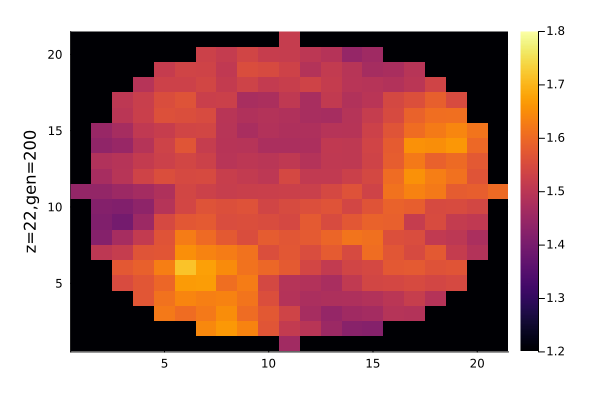

In [39]:
# Graph absolute fitness cross-section (sample)
# ------------------------------------------------

gen_no = 1200
gen_no_without_burn = gen_no - BURN_IN_GEN_N
z_slice = 22
Plots.heatmap(meanfitness_set[1][:,:,z_slice,gen_no],clims=(1.2,1.8),ylabel="z=$z_slice,gen=$gen_no_without_burn")

┌ Info: Saved animation to d:\Coding\ADMRE-Yuri\animations\3d_ra_gridrefl3_analysis.ipynb-slice-1.gif
└ @ Plots C:\Users\Hartree\.julia\packages\Plots\B5j7d\src\animation.jl:156


Plots.AnimatedGif("d:\\Coding\\ADMRE-Yuri\\animations\\3d_ra_gridrefl3_analysis.ipynb-slice-1.gif")
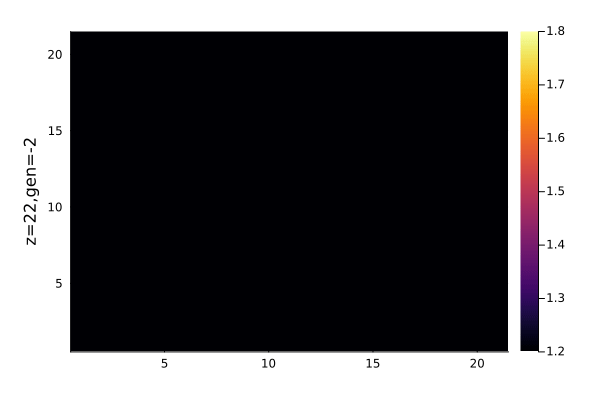

In [46]:
# Graph absolute fitness cross-section (amination for 1 replicate)
# ------------------------------------------------

gen_start = 998
gen_end = 1200
z_slice = 22

anim = @animate for i ∈ gen_start:(gen_end-1)
    i_without_burn = i - BURN_IN_GEN_N
    Plots.heatmap(meanfitness_set[1][:,:,z_slice,i],clims=(1.2,1.8),ylabel="z=$z_slice,gen=$i_without_burn")
end
gif(anim,"../animations/$thisfilename-slice-1.gif")

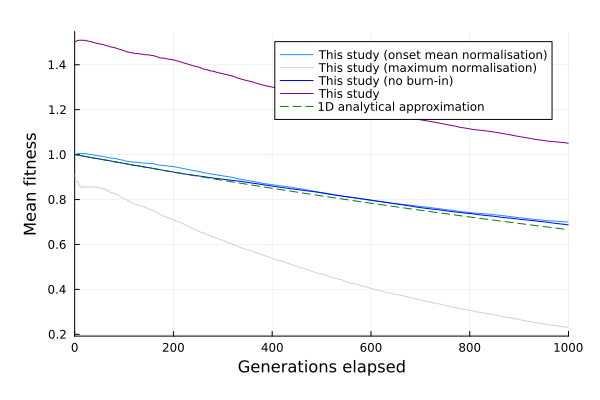

In [32]:
Plots.plot(mf_front_average_then_norm2[BURN_IN_GEN_N+1:end],color="dodgerblue",label = "This study (onset mean normalisation)",xlims=(0,1000),xlabel="Generations elapsed",ylabel="Mean fitness")
Plots.plot!(mf_front_norm_average1[BURN_IN_GEN_N+1:end],label = "This study (maximum normalisation)",color="lightgrey")
Plots.plot!(mf_front_average_noburn[BURN_IN_GEN_N+1:end],label = "This study (no burn-in)",color="blue") #,legend=(0.51,0.75))
Plots.plot!(mf_front_average[BURN_IN_GEN_N+1:end],label = "This study",color="purple")
Plots.plot!(find_mf_theory(1;mu_func=mu_effect_test2)[BURN_IN_GEN_N+1:end],label = "1D analytical approximation",linestyle=:dash,color="green",legend=:topright)
#vline!([960],style=:dash,color=:gray,label=:none)

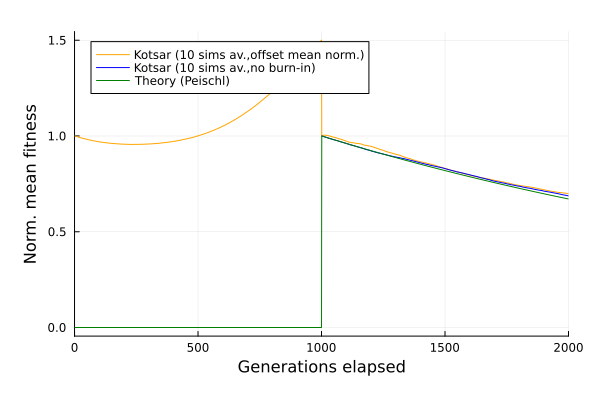

In [33]:
Plots.plot(mf_front_norm_average2,color="orange",label = "Kotsar ($N_IN_BATCH sims av.,offset mean norm.)",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness")
Plots.plot!(mf_front_average_noburn,color="blue",label = "Kotsar ($N_IN_BATCH sims av.,no burn-in)",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness")
Plots.plot!(find_mf_theory(1),label = "Theory (Peischl)",color="green",legend=:topleft)

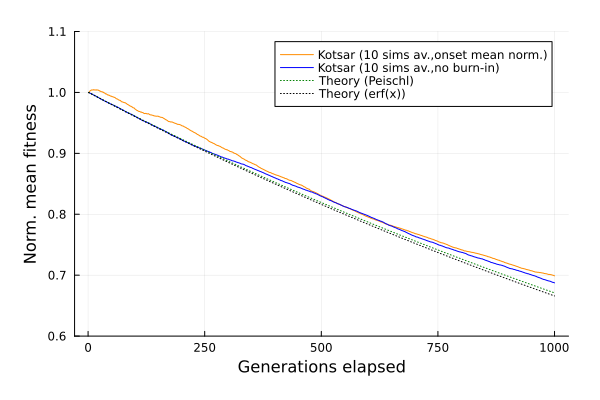

In [34]:
Plots.plot(mf_front_norm_average2[BURN_IN_GEN_N+1:end], color="darkorange", label="Kotsar ($N_IN_BATCH sims av.,onset mean norm.)", xlabel="Generations elapsed", ylabel="Norm. mean fitness", ylims=(0.6, 1.1))
#plot!(mf_front_norm_average[BURN_IN_GEN_N+1:end], color="purple", label="Kotsar ($N_IN_BATCH sims av.,max norm.)", xlabel="Generations elapsed", ylabel="Norm. mean fitness", ylims=(0.6, 1.1))
Plots.plot!(mf_front_average_noburn[BURN_IN_GEN_N+1:end], color="blue", label="Kotsar ($N_IN_BATCH sims av.,no burn-in)", xlabel="Generations elapsed", ylabel="Norm. mean fitness")
Plots.plot!(find_mf_theory(1)[BURN_IN_GEN_N+1:end], label="Theory (Peischl)", color="green", linestyle=:dot)
Plots.plot!(find_mf_theory(1; mu_func=mu_effect_test2)[BURN_IN_GEN_N+1:end], label="Theory (erf(x))", color="black", linestyle=:dot)